In [1]:
#Inspired by https://avandekleut.github.io/vae/
import torch;
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
class FF(nn.Module):
    def __init__(self,dim1,dim2,dim3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=dim1, out_features=dim2),
            nn.ReLU(),
            nn.Linear(in_features=dim2, out_features=dim3)
        )

    def forward(self, input):
        return self.main(input)
tmp = FF(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)

FF(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)
torch.Size([10, 1, 2])


In [4]:
class Autoencoder(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super().__init__()
        self.encoder = FF(dim1, dim2, dim3)
        self.decoder = nn.Sequential(
            FF(dim3, dim2, dim1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
tmp = Autoencoder(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)

Autoencoder(
  (encoder): FF(
    (main): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=2, bias=True)
    )
  )
  (decoder): Sequential(
    (0): FF(
      (main): Sequential(
        (0): Linear(in_features=2, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
    (1): Sigmoid()
  )
)
torch.Size([10, 1, 784])


In [5]:
def train(data_loader, model, optimizer, loss_function, epochs=20):
    model.to(device) # GPU
    losses = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device) # GPU
            optimizer.zero_grad()
            x_hat = model(x)
            loss = loss_function(x, x_hat)
            losses.append(loss.clone().detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"{epoch}/{i}: {loss}")
    return (model, losses)

In [6]:
def plot_latent(data_loader, encoder, dim1=0, dim2=1, num_batches=100):
    for i, (x, y) in enumerate(data_loader):
        z = encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0, dim1], z[:, 0, dim2], c=y, alpha=0.5)
        if i > num_batches:
            plt.colorbar()
            break

In [7]:
def plot_reconstructed(decoder, w, h, r0=(-10, 10), r1=(-10, 10), n=12):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).view(1,1,2).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(w, h).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [8]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x,start_dim=-2))
])

data = datasets.MNIST('./data',transform=transform,download=True)

n, w, h = data.data.shape

data_loader = torch.utils.data.DataLoader(data,batch_size=128,shuffle=True)

model = Autoencoder(w*h, 512, 2)

optimizer = torch.optim.Adam(model.parameters())

loss_function = torch.nn.MSELoss()

(autoencoder, losses) = train(data_loader, model, optimizer, loss_function,20)

0/0: 0.232472226023674
0/100: 0.05583632364869118
0/200: 0.05311201512813568
0/300: 0.05357355624437332
0/400: 0.05261654779314995
1/0: 0.047543760389089584
1/100: 0.05121143162250519
1/200: 0.048533905297517776
1/300: 0.04878471791744232
1/400: 0.04648816958069801
2/0: 0.047858696430921555
2/100: 0.04371911287307739
2/200: 0.045562732964754105
2/300: 0.04576148837804794
2/400: 0.04441356658935547
3/0: 0.045676592737436295
3/100: 0.04478829726576805
3/200: 0.045317914336919785
3/300: 0.04671042412519455
3/400: 0.04658995196223259
4/0: 0.043301329016685486
4/100: 0.040690936148166656
4/200: 0.04315318912267685
4/300: 0.04221279174089432
4/400: 0.04331539571285248
5/0: 0.043645236641168594
5/100: 0.041710395365953445
5/200: 0.044572580605745316
5/300: 0.0418943390250206
5/400: 0.0433209054172039
6/0: 0.04287269338965416
6/100: 0.040056951344013214
6/200: 0.04411047324538231
6/300: 0.04104993864893913
6/400: 0.043251629918813705
7/0: 0.0400155745446682
7/100: 0.040632084012031555
7/200: 0

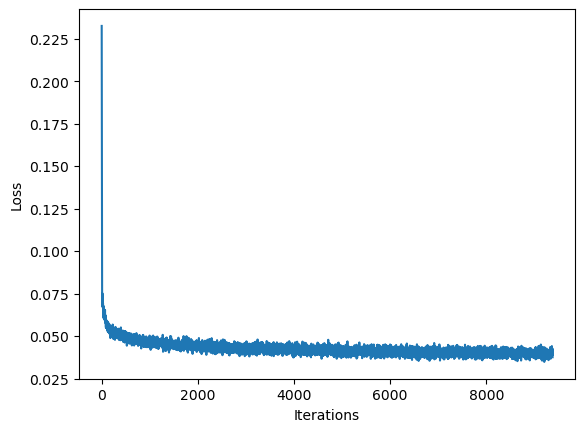

In [9]:
# Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the losses
plt.plot(losses)

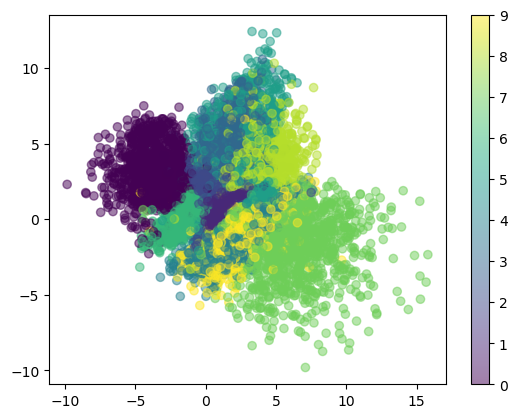

In [10]:
# Plot latent space
plot_latent(data_loader, autoencoder.encoder)
plt.savefig('latent.pdf')

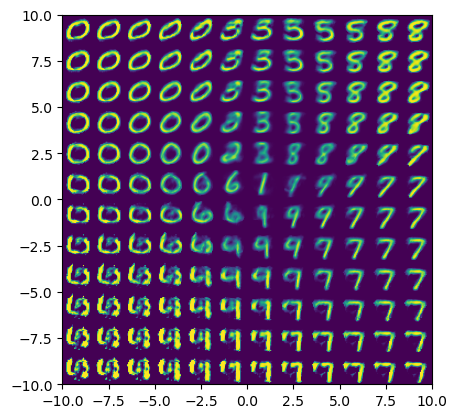

In [11]:
# Generate samples from latent space
plot_reconstructed(autoencoder.decoder,w,h)
plt.savefig('reconstruction.pdf')

In [12]:
# Plot reconstruction error versus number of latent nodes
